In [0]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
# layers
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, \
  Concatenate
# Model
from tensorflow.keras.models import Model
# optimizers
from tensorflow.keras.optimizers import SGD, Adam

# additional imports
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
# data is from : https://grouplens.org/datasets/movielens/

!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

File ‘ml-20m.zip’ already there; not retrieving.



In [0]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip


In [0]:
!ls

ml-20m	ml-20m.zip  sample_data


In [0]:
# what we want to use is ratings.csv
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [0]:
# sort the data by timestamp
df.sort_values(by=['timestamp'], inplace = True)
df.head()

,userId,movieId,rating,timestamp
4182421,28507,1176,4.0,789652004
18950979,131160,1079,3.0,789652009
18950936,131160,47,5.0,789652009
18950930,131160,21,3.0,789652009
12341178,85252,45,3.0,822873600


In [0]:
# We can't trust the userId and movieId to be numbered 0...N-1
# for example if the ids are 1,2,1million then the feature vector
# has the size of over one million
# So let's just set our own ids

# Manually
# current_user_id = 0
# custom_user_map = {} # old user id > new user id
# def map_user_id(row):
#   global current_user_id, custom_user_map
#   old_user_id = row['userId']
#   if old_user_id not in custom_user_map:
#     custom_user_map[old_user_id] = current_user_id
#     current_user_id += 1
#   return custom_user_map[old_user_id]
# df['new_movie_id'] = df.apply(map_movie_id, axis = 1)

# By using API
df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

In [0]:
# Now do the same thing for movie ids
# current_movie_id = 0
# custom_movie_map = {} # old movie id > new movie id
# def map_movie_id(row):
#   global current_movie_id, custom_movie_map
#   old_movie_id = row['movieId']
#   if old_movie_id not in custom_movie_map:
#     custom_movie_map[old_movie_id] = current_movie_id
#     current_movie_id += 1
#   return custom_movie_map[old_movie_id]

# df['new_movie_id'] = df.apply(map_movie_id, axis = 1)

# by using pandas

df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [0]:
# Get user IDs, movie IDs and ratings as separate arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values

In [0]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))
print('Number of users is {} and number of movies is {}'.format(N,M))
# Set embedding dimension
K = 10 # hyper-parameter

Number of users is 138493 and number of movies is 26744


In [0]:
# make a neural network by using functional api
# since the processes are parallel, we can't use sequential api here

# user input
u = Input(shape=(1,)) # a users are in single integer

# movie input
m = Input(shape=(1,)) # same as users

# user embedding
u_emb = Embedding(N, K)(u) # output is (num_samples, 1, K)

# movie embedding
m_emb = Embedding(M, K)(m) # output is (num_samples, 1, K)

# Flatten both embeddings since we concatenate them into a feature vector
u_emb = Flatten()(u_emb) # now its (num_samples, K)
m_emb = Flatten()(m_emb) # same as above

# Concatenate user-movie embeddings into a feature vector
x = Concatenate()([u_emb, m_emb]) # now it's (num_samples, 2K)

# Now that we have a feature vector, it's just a reguler ANN
# There are 2 common approaches for making ANN
# first one is more deep, we have less units but more layers
# the second one is wide, we have less layers but more units
x = Dense(1024, activation = 'relu')(x)
# x = Dense(400, activation = 'relu')(x)
# x = Dense(400, activation = 'relu')(x)
x = Dense(1)(x)

In [0]:
model = Model(inputs = [u,m], outputs = x)
model.compile(
    loss = 'mse',
    metrics = ['mse', 'mae'],
    optimizer = SGD(lr = 0.08, momentum = 0.9)
)

In [0]:
# shuffle the data
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)
# I'll use the 80% of the data for training and the 20% for testing
Ntrain = int(0.8 * len(ratings))
#
train_user = user_ids[:Ntrain]
train_movie = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]
#
test_user = user_ids[Ntrain:]
test_movie = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

# center the ratings
# you can also divide the data by std but don't forget to scale it back to calculate mse correctly
avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating
test_ratings = test_ratings - avg_rating

In [0]:
# fit the model
r = model.fit(
    x = [train_user, train_movie],
    y = train_ratings,
    epochs = 25,
    batch_size = 1024, # we have too much data
    verbose = 2, # goes a little faster when you don't print the progress bar
    validation_data = ([test_user, test_movie], test_ratings),
)

Train on 16000210 samples, validate on 4000053 samples
Epoch 1/25
16000210/16000210 - 151s - loss: 0.7775 - mse: 0.7775 - mae: 0.6788 - val_loss: 0.7217 - val_mse: 0.7217 - val_mae: 0.6531
Epoch 2/25
16000210/16000210 - 149s - loss: 0.7015 - mse: 0.7015 - mae: 0.6422 - val_loss: 0.6965 - val_mse: 0.6965 - val_mae: 0.6408
Epoch 3/25
16000210/16000210 - 151s - loss: 0.6782 - mse: 0.6782 - mae: 0.6309 - val_loss: 0.6833 - val_mse: 0.6833 - val_mae: 0.6356
Epoch 4/25
16000210/16000210 - 153s - loss: 0.6630 - mse: 0.6630 - mae: 0.6234 - val_loss: 0.6770 - val_mse: 0.6770 - val_mae: 0.6261
Epoch 5/25
16000210/16000210 - 155s - loss: 0.6520 - mse: 0.6520 - mae: 0.6179 - val_loss: 0.6697 - val_mse: 0.6697 - val_mae: 0.6272
Epoch 6/25
16000210/16000210 - 156s - loss: 0.6375 - mse: 0.6375 - mae: 0.6107 - val_loss: 0.6545 - val_mse: 0.6545 - val_mae: 0.6172
Epoch 7/25
16000210/16000210 - 162s - loss: 0.6195 - mse: 0.6195 - mae: 0.6017 - val_loss: 0.6479 - val_mse: 0.6479 - val_mae: 0.6122
Epoch 8

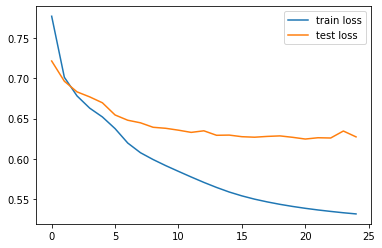

In [0]:
# plot the losses
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'test loss')
plt.legend()
plt.show()

In [0]:
# is this approach on par with other approaches?
# source: https://datascience.stackexchange.com/questions/29740/benchmark-result-for-movielens-dataset
# usually the score that matters is the rmse so lets take the square root of mse
print(np.sqrt(r.history['val_mse'][-1])) # validation rmse
print(np.sqrt(r.history['mse'][-1])) # training rmse 
# as a result, we can say that our approach is on par or even better than some of the state-of-art approaches.

0.7919524
0.7288157
